# Cài Đặt Thư Viện và Tải Dữ Liệu

In [ ]:
# import dataset
!gdown 1Dh_y7gFDUa2sD72_cKIa209dhbMVoGEd

Downloading...
From: https://drive.google.com/uc?id=1Dh_y7gFDUa2sD72_cKIa209dhbMVoGEd
To: /content/train-house-prices-advanced-regression-techniques.csv
100% 461k/461k [00:00<00:00, 113MB/s]


In [ ]:
!pip install -q category_encoders optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 18.8 MB/s eta 0:00:00


# Import Thư Viện và Cấu Hình Ban Đầu

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize

# Sklearn preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, MinMaxScaler,
                                   StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, PolynomialFeatures)
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Sklearn models and metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, RANSACRegressor, QuantileRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna for hyperparameter tuning
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Phân Tích Dữ Liệu (EDA)

Định nghĩa hàm **`quick_eda`** để thực hiện phân tích dữ liệu khám phá ngắn gọn: hiển thị hình dạng dữ liệu, thống kê mục tiêu, phân phối, giá trị thiếu, độ lệch và tương quan. Sau đó tải dữ liệu từ file CSV và chạy EDA.

In [ ]:
def quick_eda(df, target_col='SalePrice'):
    """Perform concise exploratory data analysis"""
    print(f"Dataset shape: {df.shape}")
    print(f"\nTarget stats:\n{df[target_col].describe()}")

    # Distribution plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[target_col], kde=True, ax=axes[0])
    axes[0].set_title(f'{target_col} Distribution')

    # Missing values
    missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
    if len(missing) > 0:
        missing[:15].plot.barh(ax=axes[1], color='skyblue')
        axes[1].set_title('Top 15 Missing Values')
        axes[1].invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Skewness and correlations
    num_cols = df.select_dtypes(include=np.number).columns
    skew = df[num_cols].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
    print(f"\nHighly skewed columns (|skew| > 1):\n{skew[abs(skew) > 1].head(10)}")

    if target_col in num_cols:
        corr = df[num_cols].corr()[target_col].sort_values(ascending=False)
        print(f"\nTop correlations with {target_col}:\n{corr.head(8)}")

    return skew, missing

Dataset shape: (1460, 81)

Target stats:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


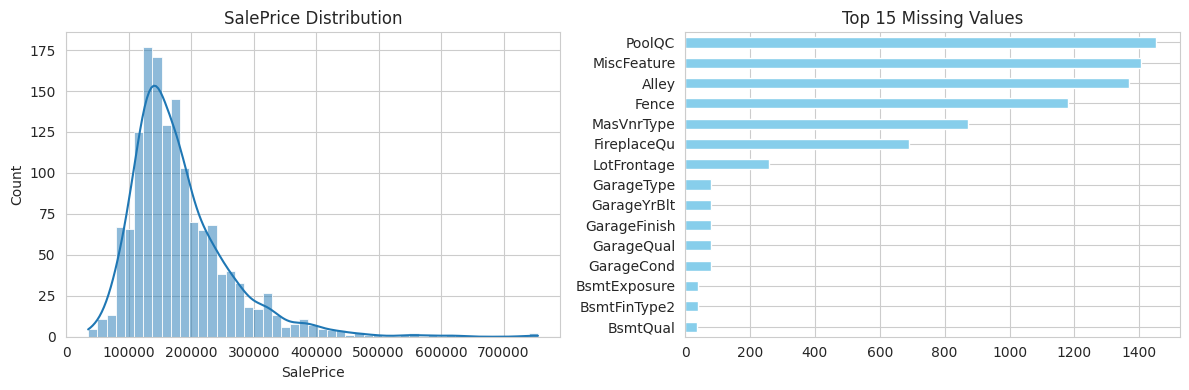


Highly skewed columns (|skew| > 1):
MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
dtype: float64

Top correlations with SalePrice:
SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
Name: SalePrice, dtype: float64


In [ ]:
# Load dataset
df = pd.read_csv("train-house-prices-advanced-regression-techniques.csv")
print("=" * 60)
skew_stats, missing_stats = quick_eda(df)
print("=" * 60)

# Chuẩn Bị Dữ Liệu và Tiền xử lý dữ liệu

Định nghĩa các hàm xử lý dữ liệu cốt lõi, bao gồm tách tập dữ liệu, tạo tính năng mới (FE), và xử lý ngoại lai (Outliers).

* **`prepare_data`**:
      * **Loại bỏ cột**: `Id` (không có giá trị dự đoán), `Alley`, `PoolQC`, `Fence`, `MiscFeature` (có tỷ lệ thiếu quá cao, hơn 50%).
      * **Điền khuyết tạm thời**: Điền `NaN` trong cột **phân loại** bằng 'none' để tránh lỗi khi tách tập dữ liệu. Việc điền khuyết **thực tế** sẽ được thực hiện sau đó trong Pipeline bằng các kỹ thuật tinh vi hơn.

* **`add_features`**: Tạo ra các biến tổng hợp quan trọng, thường mang lại ý nghĩa kinh doanh tốt hơn:
    * `Age` (Tuổi của nhà): `YrSold` - `YearBuilt`. Biến này trực quan hơn so với 2 biến rời rạc.
    * `TotalSF` (Tổng diện tích): `GrLivArea` + `TotalBsmtSF`. Kết hợp diện tích sống trên mặt đất và dưới tầng hầm.
    * `TotalBath` (Tổng số phòng tắm): Tổng hợp các loại phòng tắm (đầy đủ và nửa phòng) thành một chỉ số tiện nghi duy nhất.

* **Xử lý Ngoại lai**:
    * **`winsorize_func`**: Cắt bớt các giá trị ngoại lai ở hai đầu (2% và 5%). Đây là phương pháp ít gây biến dạng dữ liệu hơn việc loại bỏ hoàn toàn, giúp giữ lại kích thước mẫu.

    * **`iqr_clip_func`**: Cắt bớt các giá trị vượt ra ngoài ngưỡng $Q1 - 1.5 \times IQR$ và $Q3 + 1.5 \times IQR$.


In [ ]:
def prepare_data(df, target_col='SalePrice', test_size=0.25, random_state=42):
    """Split data and identify column types"""
    # Drop high-missing columns and ID
    drop_cols = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
    df = df.drop([col for col in drop_cols if col in df.columns], axis=1)

    # Train-test split
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Separate target
    y_train = train_df[target_col].values
    y_test = test_df[target_col].values
    X_train = train_df.drop(target_col, axis=1)
    X_test = test_df.drop(target_col, axis=1)

    # Identify column types
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

    # Fill categorical NaNs with 'none' for initial processing
    X_train[cat_cols] = X_train[cat_cols].fillna('none')
    X_test[cat_cols] = X_test[cat_cols].fillna('none')

    return X_train, X_test, y_train, y_test, num_cols, cat_cols

def add_features(X_train, X_test, num_cols):
    """Add engineered features"""
    X_train = X_train.copy()
    X_test = X_test.copy()
    new_features = []

    for df in [X_train, X_test]:
        if 'YrSold' in df.columns and 'YearBuilt' in df.columns:
            df['Age'] = df['YrSold'] - df['YearBuilt']
            if 'Age' not in new_features:
                new_features.append('Age')

        if 'GrLivArea' in df.columns and 'TotalBsmtSF' in df.columns:
            df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF'].fillna(0)
            if 'TotalSF' not in new_features:
                new_features.append('TotalSF')

        if all(c in df.columns for c in ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']):
            df['TotalBath'] = (df['FullBath'].fillna(0) + df['HalfBath'].fillna(0) * 0.5 +
                              df['BsmtFullBath'].fillna(0) + df['BsmtHalfBath'].fillna(0) * 0.5)
            if 'TotalBath' not in new_features:
                new_features.append('TotalBath')

        # if 'PoolArea' in df.columns:
        #     df['HasPool'] = (df['PoolArea'] > 0).astype(int)
        #     if 'HasPool' not in new_features:
        #         new_features.append('HasPool')

        # if 'TotalBsmtSF' in df.columns:
        #     df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)
        #     if 'HasBsmt' not in new_features:
        #         new_features.append('HasBsmt')

        # if '2ndFlrSF' in df.columns:
        #     df['Has2ndFlr'] = (df['2ndFlrSF'] > 0).astype(int)
        #     if 'Has2ndFlr' not in new_features:
        #         new_features.append('Has2ndFlr')

    # Update numeric columns
    updated_num_cols = num_cols + [f for f in new_features if f in X_train.columns]
    return X_train, X_test, updated_num_cols

def winsorize_func(X):
    """Winsorize outliers at 2% and 5% tails"""
    return np.apply_along_axis(lambda x: winsorize(x, limits=[0.02, 0.05]), 0, X)

def iqr_clip_func(X):
    """Clip outliers using IQR method"""
    Q1, Q3 = np.percentile(X, [25, 75], axis=0)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return np.clip(X, lower, upper)

# Chuẩn Bị Dữ Liệu và Định Nghĩa Cấu Hình Pipeline

Thực thi chuẩn bị dữ liệu và xác định các tham số cho việc thử nghiệm hàng loạt Pipeline.

* **Log-Transform Biến Mục Tiêu**: Nếu `SalePrice` có độ xiên ($|\text{skew}| > 1$), ta áp dụng $\text{log}(1+y)$ (`np.log1p`). Điều này giúp **chuẩn hóa** phân phối biến mục tiêu, làm giảm ảnh hưởng của các giá nhà rất cao (ngoại lai), từ đó cải thiện hiệu suất của các mô hình hồi quy tuyến tính.

* **Phân loại Cột**: Tách cột phân loại thành **thứ tự (Ordinal)** và **danh nghĩa (Nominal)**.
    * **Ordinal**: Có thứ bậc (ví dụ: 'ExterQual': Poor $\to$ Excellent). Sẽ được mã hóa bằng `OrdinalEncoder` (gán số).

    * **Nominal**: Không có thứ bậc (ví dụ: `MSZoning`). Sẽ được mã hóa bằng `OneHotEncoder` (tạo biến giả).

* **Tùy chọn Pipeline**: Việc định nghĩa nhiều tùy chọn cho Imputer (`Simple`, `Iterative`, `KNN`), Outlier Handler (`Winsor`, `IQR`), Skew Transformer (`Log1p`, `Yeo-Johnson`), và Scaler (`MinMax`, `Standard`, `Robust`) cho phép ta **tự động hóa việc thử nghiệm** hàng trăm tổ hợp tiền xử lý $\times$ mô hình để tìm ra cấu hình tốt nhất.


In [ ]:
# Prepare data
X_train, X_test, y_train, y_test, num_cols, cat_cols = prepare_data(df)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Numerical: {len(num_cols)}, Categorical: {len(cat_cols)}")

# Check if target is skewed and transform if needed
y_skew = stats.skew(y_train)
y_log_transform = abs(y_skew) > 1
if y_log_transform:
    y_train_transformed = np.log1p(y_train)
    y_test_transformed = np.log1p(y_test)
    print(f"\nTarget skew: {y_skew:.2f} - Applied log1p transform")
else:
    y_train_transformed = y_train
    y_test_transformed = y_test

ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
ordinal_cols = [c for c in ordinal_cols if c in cat_cols]
nominal_cols = [c for c in cat_cols if c not in ordinal_cols]

# Replace the poly_features dictionary with:
poly_features = {
    'None': 'passthrough',
    'Poly': Pipeline([
        ('impute_check', SimpleImputer(strategy='mean')),  # Ensure no NaNs
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
    ])
}

# Define pipeline component options
imputers = {
    'Simple': SimpleImputer(strategy='mean'),
    'Iterative': IterativeImputer(random_state=42, max_iter=10),
    'KNN': KNNImputer(n_neighbors=5)
}

outlier_handlers = {
    'None': 'passthrough',
    'Winsor': FunctionTransformer(winsorize_func, validate=False),
    'IQR': FunctionTransformer(iqr_clip_func, validate=False)
}

skew_transformers = {
    'None': 'passthrough',
    'Log1p': FunctionTransformer(np.log1p, validate=False),
    'YeoJohnson': PowerTransformer(method='yeo-johnson', standardize=False)
}

scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

# Ordinal encoder with proper ordering
ordinal_categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']] * len(ordinal_cols)


Train shape: (1095, 75), Test shape: (365, 75)
Numerical: 36, Categorical: 39

Target skew: 1.75 - Applied log1p transform


# Xây Dựng và Đánh Giá Pipeline

Định nghĩa hàm tạo Pipeline và hàm đánh giá, là trái tim của quy trình đánh giá tự động.

* **`create_pipeline`**: Sử dụng `ColumnTransformer` để áp dụng các bước tiền xử lý khác nhau cho các loại cột khác nhau (**Cột số** $\to$ Impute, Outlier, Skew Transform, Scale; **Cột phân loại** $\to$ Ordinal/OneHot Encode). Điều này đảm bảo tính toàn vẹn của dữ liệu và tránh Data Leakage (mỗi bước chỉ `fit` trên tập huấn luyện).
* **`evaluate_pipeline`**:
    * **Inverse Transform**: Đây là bước **quan trọng nhất** nếu biến mục tiêu đã được log-transform. Kết quả dự đoán (`y_pred`) phải được đưa về thang đo ban đầu bằng $\exp(y) - 1$ (`np.expm1`) trước khi tính các metric như RMSE.
    * **Metric RAE (Relative Absolute Error)**: Cung cấp thước đo về hiệu suất so với một mô hình cơ sở (dự đoán bằng giá trị trung bình).

In [ ]:
def create_pipeline(imputer, outlier, skew_tf, scaler, use_ordinal=False, num_cols_list=None):
    """Create preprocessing pipeline with specified components"""
    if num_cols_list is None:
        num_cols_list = num_cols

    num_steps = [
        ('impute', imputer),
        ('outlier', outlier),
        ('skew', skew_tf),
        ('scale', scaler)
    ]
    num_pipeline = Pipeline([s for s in num_steps if s[1] != 'passthrough'])

    if use_ordinal and len(ordinal_cols) > 0:
        cat_transformers = [
            ('ordinal', OrdinalEncoder(categories=ordinal_categories,
                                      handle_unknown='use_encoded_value',
                                      unknown_value=-1), ordinal_cols),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols)
        ]
    else:
        cat_transformers = [
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ]

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols_list)
    ] + cat_transformers)

    return preprocessor

def calculate_rae(y_true, y_pred):
    """Calculate Relative Absolute Error"""
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

def evaluate_pipeline(pipeline_name, preprocessor, model, X_tr, X_te, y_tr, y_te, inverse_transform=False):
    """Fit pipeline, predict, and calculate metrics"""
    # Fit preprocessing and model
    X_tr_processed = preprocessor.fit_transform(X_tr)
    X_te_processed = preprocessor.transform(X_te)

    model.fit(X_tr_processed, y_tr)
    y_tr_pred = model.predict(X_tr_processed)
    y_te_pred = model.predict(X_te_processed)

    # Inverse transform if target was log-transformed
    if inverse_transform:
        y_tr_pred = np.expm1(y_tr_pred)
        y_te_pred = np.expm1(y_te_pred)
        y_tr_actual = np.expm1(y_tr)
        y_te_actual = np.expm1(y_te)
    else:
        y_tr_actual = y_tr
        y_te_actual = y_te

    # Calculate metrics
    metrics = {
        'Pipeline': pipeline_name,
        'Train_RMSE': np.sqrt(mean_squared_error(y_tr_actual, y_tr_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_te_actual, y_te_pred)),
        'Train_RAE': calculate_rae(y_tr_actual, y_tr_pred),
        'Test_RAE': calculate_rae(y_te_actual, y_te_pred),
        'Train_R2': r2_score(y_tr_actual, y_tr_pred),
        'Test_R2': r2_score(y_te_actual, y_te_pred)
    }

    return metrics, X_tr_processed, X_te_processed

# Thử Nghiệm và Đánh Giá Các Cấu Hình Pipeline (Giai đoạn 1)

* **Thử nghiệm Hệ thống**: Đây là một phương pháp **tìm kiếm lưới (Grid Search)** thủ công nhưng có kiểm soát hơn. Ta cố định một số thành phần và thay đổi các thành phần khác (Imputer, Outlier, Skew, Scaler) để đánh giá tầm quan trọng của từng bước tiền xử lý.

* **Đánh giá Mô hình**: Sử dụng các mô hình hồi quy tuyến tính (Linear, Ridge, Lasso, ElasticNet) và các mô hình mạnh mẽ hơn với ngoại lai (Huber, RANSAC, Quantile) để đảm bảo tính ổn định và đa dạng của kết quả.

In [ ]:
pipeline_configs = [
    # Vary imputation with fixed other components
    ('Simple_Log_Winsor_Standard_OneHot', 'Simple', 'Winsor', 'Log1p', 'Standard', False),
    ('Iterative_Log_Winsor_Standard_OneHot', 'Iterative', 'Winsor', 'Log1p', 'Standard', False),
    ('KNN_Log_Winsor_Standard_OneHot', 'KNN', 'Winsor', 'Log1p', 'Standard', False),

    # Vary outlier handling
    ('Iterative_Log_IQR_Standard_OneHot', 'Iterative', 'IQR', 'Log1p', 'Standard', False),
    ('Iterative_Log_None_Standard_OneHot', 'Iterative', 'None', 'Log1p', 'Standard', False),

    # Vary skew transformation
    ('Iterative_YeoJohnson_Winsor_Standard_OneHot', 'Iterative', 'Winsor', 'YeoJohnson', 'Standard', False),
    ('Iterative_None_Winsor_Standard_OneHot', 'Iterative', 'Winsor', 'None', 'Standard', False),

    # Vary scaling
    ('Iterative_Log_Winsor_MinMax_OneHot', 'Iterative', 'Winsor', 'Log1p', 'MinMax', False),
    ('Iterative_Log_Winsor_Robust_OneHot', 'Iterative', 'Winsor', 'Log1p', 'Robust', False),

    # Try ordinal encoding
    ('Iterative_Log_Winsor_Standard_Ordinal', 'Iterative', 'Winsor', 'Log1p', 'Standard', True),
    ('Simple_Log_Winsor_MinMax_Ordinal', 'Simple', 'Winsor', 'Log1p', 'MinMax', True),

    # More combinations
    ('KNN_YeoJohnson_IQR_Robust_OneHot', 'KNN', 'IQR', 'YeoJohnson', 'Robust', False),
    ('Simple_None_None_MinMax_OneHot', 'Simple', 'None', 'None', 'MinMax', False),
    ('KNN_Log_None_Standard_OneHot', 'KNN', 'None', 'Log1p', 'Standard', False),
    ('Iterative_YeoJohnson_IQR_MinMax_OneHot', 'Iterative', 'IQR', 'YeoJohnson', 'MinMax', False),
    ('Simple_YeoJohnson_Winsor_Robust_OneHot', 'Simple', 'Winsor', 'YeoJohnson', 'Robust', False),
    ('KNN_None_IQR_MinMax_OneHot', 'KNN', 'IQR', 'None', 'MinMax', False),
    ('Simple_Log_IQR_Standard_Ordinal', 'Simple', 'IQR', 'Log1p', 'Standard', True),
    ('Iterative_None_IQR_Robust_OneHot', 'Iterative', 'IQR', 'None', 'Robust', False),
    ('KNN_YeoJohnson_Winsor_MinMax_Ordinal', 'KNN', 'Winsor', 'YeoJohnson', 'MinMax', True),
    ('Simple_Log_None_Robust_OneHot', 'Simple', 'None', 'Log1p', 'Robust', False),
]

# pipeline_configs = [
#     ('Simple_Log_Winsor_Standard_OneHot', 'Simple', 'Winsor', 'Log1p', 'Standard', False),
#     ('Iterative_Log_Winsor_Standard_OneHot', 'Iterative', 'Winsor', 'Log1p', 'Standard', False),
#     ('KNN_Log_Winsor_Standard_OneHot', 'KNN', 'Winsor', 'Log1p', 'Standard', False),
#     ('Iterative_Log_IQR_Standard_OneHot', 'Iterative', 'IQR', 'Log1p', 'Standard', False),
#     ('Iterative_YeoJohnson_Winsor_Standard_OneHot', 'Iterative', 'Winsor', 'YeoJohnson', 'Standard', False),
#     ('Iterative_Log_Winsor_MinMax_OneHot', 'Iterative', 'Winsor', 'Log1p', 'MinMax', False),
#     ('Iterative_Log_Winsor_Robust_OneHot', 'Iterative', 'Winsor', 'Log1p', 'Robust', False),
#     ('Iterative_Log_Winsor_Standard_Ordinal', 'Iterative', 'Winsor', 'Log1p', 'Standard', True),
#     ('KNN_YeoJohnson_IQR_Robust_OneHot', 'KNN', 'IQR', 'YeoJohnson', 'Robust', False),
#     ('Simple_Log_Winsor_MinMax_OneHot', 'Simple', 'Winsor', 'Log1p', 'MinMax', False),
#     ('KNN_Log_None_Standard_OneHot', 'KNN', 'None', 'Log1p', 'Standard', False),
#     ('Simple_YeoJohnson_Winsor_Robust_OneHot', 'Simple', 'Winsor', 'YeoJohnson', 'Robust', False),
#     ('Iterative_None_IQR_Robust_OneHot', 'Iterative', 'IQR', 'None', 'Robust', False),
#     ('Simple_Log_IQR_Standard_OneHot', 'Simple', 'IQR', 'Log1p', 'Standard', False),
#     ('KNN_YeoJohnson_Winsor_MinMax_OneHot', 'KNN', 'Winsor', 'YeoJohnson', 'MinMax', False),
# ]


# Evaluate all combinations
models_to_test = {
    'LinearReg': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000),
    'Huber': HuberRegressor(epsilon=1.35, max_iter=1000),
    'RANSAC': RANSACRegressor(random_state=42),
    'Quantile': QuantileRegressor(quantile=0.5, alpha=0.001, solver='highs')
}

# Huấn luyện mô hình và Đánh Giá (Giai đoạn 2)

Thực thi kỹ thuật tính năng và đánh giá lại 10 cấu hình tiền xử lý tốt nhất (không tính mô hình).

* **Đánh giá FE**: Sau khi có kết quả ban đầu, ta chỉ cần thử nghiệm FE trên các cấu hình tiền xử lý **đã được chứng minh là tốt** để tiết kiệm thời gian tính toán. Mục đích là để xem liệu các biến tổng hợp (`Age`, `TotalSF`, `TotalBath`) có cải thiện khả năng dự đoán của các mô hình hàng đầu hay không.

In [ ]:
results = []
print("\nEvaluating pipeline combinations (without FE)...")
for i, (name, imp, out, skw, scl, ord_enc) in enumerate(pipeline_configs, 1):
    preprocessor = create_pipeline(imputers[imp], outlier_handlers[out],
                                   skew_transformers[skw], scalers[scl], ord_enc, num_cols)

    for model_name, model in models_to_test.items():
        full_name = f"{name}_{model_name}"
        metrics, _, _ = evaluate_pipeline(full_name, preprocessor, model,
                                         X_train, X_test,
                                         y_train_transformed, y_test_transformed,
                                         inverse_transform=y_log_transform)
        metrics['With_FE'] = False
        results.append(metrics)

    if i % 5 == 0:
        print(f"Completed {i}/{len(pipeline_configs)} configurations...")

# Create initial results dataframe
results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False)


Evaluating pipeline combinations (without FE)...
Completed 5/21 configurations...
Completed 10/21 configurations...
Completed 15/21 configurations...
Completed 20/21 configurations...


In [ ]:
print("\nAdding feature engineering and re-evaluating top 10 pipelines...")
X_train_fe, X_test_fe, num_cols_fe = add_features(X_train, X_test, num_cols)
print(f"Added {len(num_cols_fe) - len(num_cols)} new features: {[c for c in num_cols_fe if c not in num_cols]}")

# Get top 10 unique pipeline configurations (without model suffix)
top_10_configs = results_df['Pipeline'].str.rsplit('_', n=1).str[0].unique()[:10]

fe_results = []
for config_name in top_10_configs:
    # Find original config
    matching_configs = [c for c in pipeline_configs if c[0] == config_name]
    if not matching_configs:
        continue

    config = matching_configs[0]
    name, imp, out, skw, scl, ord_enc = config
    preprocessor = create_pipeline(imputers[imp], outlier_handlers[out],
                                   skew_transformers[skw], scalers[scl], ord_enc, num_cols_fe)

    for model_name, model in models_to_test.items():
        full_name = f"{name}_{model_name}"
        metrics, _, _ = evaluate_pipeline(full_name, preprocessor, model,
                                         X_train_fe, X_test_fe,
                                         y_train_transformed, y_test_transformed,
                                         inverse_transform=y_log_transform)
        metrics['With_FE'] = True
        fe_results.append(metrics)

# Combine results
results_df = pd.concat([results_df, pd.DataFrame(fe_results)], ignore_index=True)
results_df = results_df.sort_values('Test_R2', ascending=False)

print("\n" + "=" * 80)
print("TOP 10 PIPELINE PERFORMANCES (with and without FE):")
print("=" * 80)
print(results_df.head(10)[['Pipeline', 'With_FE', 'Test_RMSE', 'Test_RAE', 'Test_R2']].to_string(index=False))


Adding feature engineering and re-evaluating top 10 pipelines...
Added 3 new features: ['Age', 'TotalSF', 'TotalBath']

TOP 10 PIPELINE PERFORMANCES (with and without FE):
                                 Pipeline  With_FE    Test_RMSE  Test_RAE  Test_R2
  Simple_None_None_MinMax_OneHot_Quantile     True 21537.201390  0.237983 0.933786
  Simple_None_None_MinMax_OneHot_Quantile    False 21635.262568  0.238105 0.933181
    Simple_None_None_MinMax_OneHot_RANSAC     True 21879.243605  0.250053 0.931666
 Simple_None_None_MinMax_OneHot_LinearReg    False 22368.655882  0.249887 0.928575
 Simple_None_None_MinMax_OneHot_LinearReg     True 22368.655882  0.249887 0.928575
     Simple_None_None_MinMax_OneHot_Huber     True 22699.113450  0.246956 0.926449
     Simple_None_None_MinMax_OneHot_Huber    False 22744.416403  0.247177 0.926155
   Simple_Log_None_Robust_OneHot_Quantile     True 22777.519824  0.231398 0.925940
Iterative_None_IQR_Robust_OneHot_Quantile    False 22781.811857  0.235064 0.9259

# Tinh Chỉnh Tham Số Siêu (Hyperparameter Tuning) với Optuna

Thực hiện tối ưu hóa tham số cho các mô hình tốt nhất.

* **`tune_model_optuna`**: Sử dụng thư viện **Optuna** và phương pháp **Tối ưu hóa Siêu Tham số Bayesian** (Bayesian Hyperparameter Optimization). Phương pháp này hiệu quả hơn tìm kiếm lưới (Grid Search) hoặc tìm kiếm ngẫu nhiên (Random Search) vì nó học hỏi từ các lần thử trước để chọn các tham số tiếp theo tốt hơn.

* **Đánh giá bằng Cross-Validation (CV)**: Sử dụng $k$-fold CV (cụ thể là `cv=3`) trên tập huấn luyện (`X_tr`) để đảm bảo rằng các tham số tốt nhất (`best_params`) không bị quá khớp (overfit) với một tập con cụ thể. RMSE CV được chọn làm metric mục tiêu để **giảm thiểu lỗi** dự đoán giá nhà.


In [ ]:
def tune_model_optuna(model_name, preprocessor, X_tr, y_tr, n_trials=20):
    """Tune model hyperparameters using Optuna"""
    X_tr_processed = preprocessor.fit_transform(X_tr)

    def objective(trial):
        if model_name == 'Ridge':
            params = {'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True)}
            model = Ridge(**params)
        elif model_name == 'Lasso':
            params = {'alpha': trial.suggest_float('alpha', 0.0001, 0.1, log=True)}
            model = Lasso(**params, max_iter=10000)
        elif model_name == 'ElasticNet':
            params = {
                'alpha': trial.suggest_float('alpha', 0.0001, 0.1, log=True),
                'l1_ratio': trial.suggest_float('l1_ratio', 0.1, 0.9)
            }
            model = ElasticNet(**params, max_iter=10000)
        elif model_name == 'Huber':
            params = {'epsilon': trial.suggest_float('epsilon', 1.1, 2.0)}
            model = HuberRegressor(**params, max_iter=1000)
        elif model_name == 'RANSAC':
            params = {'min_samples': trial.suggest_float('min_samples', 0.5, 0.9)}
            model = RANSACRegressor(**params, random_state=42)
        elif model_name == 'Quantile':
            params = {'alpha': trial.suggest_float('alpha', 0.0001, 0.1, log=True)}
            model = QuantileRegressor(**params, quantile=0.5, solver='highs')
        else:  # LinearReg
            params = {}
            model = LinearRegression()

        # Cross-validation RMSE
        scores = cross_val_score(model, X_tr_processed, y_tr,
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        rmse = np.sqrt(-scores.mean())
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    return study.best_params, study.best_value

# Tune top 10 pipelines
print("\nTuning hyperparameters for top 10 pipelines...")
tuning_results = []

top_10_rows = results_df.head(10)
for idx, row in top_10_rows.iterrows():
    pipeline_name = row['Pipeline']
    with_fe = row['With_FE']

    # Extract model name
    model_name = pipeline_name.split('_')[-1]
    config_name = '_'.join(pipeline_name.split('_')[:-1])

    # Find config
    matching_configs = [c for c in pipeline_configs if c[0] == config_name]
    if not matching_configs:
        continue

    config = matching_configs[0]
    _, imp, out, skw, scl, ord_enc = config

    # Select data
    X_tr = X_train_fe if with_fe else X_train
    X_te = X_test_fe if with_fe else X_test
    num_cols_list = num_cols_fe if with_fe else num_cols

    # Create preprocessor
    preprocessor = create_pipeline(imputers[imp], outlier_handlers[out],
                                   skew_transformers[skw], scalers[scl], ord_enc, num_cols_list)

    # Tune
    try:
        best_params, best_cv_rmse = tune_model_optuna(model_name, preprocessor, X_tr,
                                                       y_train_transformed, n_trials=20)

        # Fit with best params and evaluate on test
        X_tr_processed = preprocessor.fit_transform(X_tr)
        X_te_processed = preprocessor.transform(X_te)

        if model_name == 'Ridge':
            tuned_model = Ridge(**best_params)
        elif model_name == 'Lasso':
            tuned_model = Lasso(**best_params, max_iter=10000)
        elif model_name == 'ElasticNet':
            tuned_model = ElasticNet(**best_params, max_iter=10000)
        elif model_name == 'Huber':
            tuned_model = HuberRegressor(**best_params, max_iter=1000)
        elif model_name == 'RANSAC':
            tuned_model = RANSACRegressor(**best_params, random_state=42)
        elif model_name == 'Quantile':
            tuned_model = QuantileRegressor(**best_params, quantile=0.5, solver='highs')
        else:
            tuned_model = LinearRegression()

        tuned_model.fit(X_tr_processed, y_train_transformed)
        y_te_pred = tuned_model.predict(X_te_processed)

        if y_log_transform:
            y_te_pred = np.expm1(y_te_pred)
            y_te_actual = np.expm1(y_test_transformed)
        else:
            y_te_actual = y_test_transformed

        tuned_r2 = r2_score(y_te_actual, y_te_pred)
        tuned_rmse = np.sqrt(mean_squared_error(y_te_actual, y_te_pred))

        tuning_results.append({
            'Pipeline': pipeline_name,
            'Tuned_Params': str(best_params),
            'Tuned_Test_R2': tuned_r2,
            'Tuned_Test_RMSE': tuned_rmse
        })

        print(f"✓ {pipeline_name}: R²={tuned_r2:.4f}, Params={best_params}")
    except Exception as e:
        print(f"✗ {pipeline_name}: Tuning failed - {str(e)[:50]}")
        tuning_results.append({
            'Pipeline': pipeline_name,
            'Tuned_Params': 'Failed',
            'Tuned_Test_R2': row['Test_R2'],
            'Tuned_Test_RMSE': row['Test_RMSE']
        })


Tuning hyperparameters for top 10 pipelines...
✓ Simple_None_None_MinMax_OneHot_Quantile: R²=0.9287, Params={'alpha': 0.0034331500866495545}
✓ Simple_None_None_MinMax_OneHot_Quantile: R²=0.9281, Params={'alpha': 0.0034988391148688697}
✓ Simple_None_None_MinMax_OneHot_RANSAC: R²=0.9318, Params={'min_samples': 0.8956018810622906}
✓ Simple_None_None_MinMax_OneHot_LinearReg: R²=0.9286, Params={}
✓ Simple_None_None_MinMax_OneHot_LinearReg: R²=0.9286, Params={}
✓ Simple_None_None_MinMax_OneHot_Huber: R²=0.9260, Params={'epsilon': 1.9946199551401165}
✓ Simple_None_None_MinMax_OneHot_Huber: R²=0.9259, Params={'epsilon': 1.9963635850045445}
✓ Simple_Log_None_Robust_OneHot_Quantile: R²=0.9219, Params={'alpha': 0.0031294827419807267}
✓ Iterative_None_IQR_Robust_OneHot_Quantile: R²=0.9150, Params={'alpha': 0.004022770665268161}
✓ KNN_None_IQR_MinMax_OneHot_Quantile: R²=0.9082, Params={'alpha': 0.0032931366529680927}


In [ ]:
# Merge tuning results
tuning_df = pd.DataFrame(tuning_results)
results_df = results_df.merge(tuning_df, on='Pipeline', how='left')
results_df['Tuned_Test_R2'] = results_df['Tuned_Test_R2'].fillna(results_df['Test_R2'])
results_df['Tuned_Test_RMSE'] = results_df['Tuned_Test_RMSE'].fillna(results_df['Test_RMSE'])
results_df = results_df.sort_values('Tuned_Test_R2', ascending=False)

print("\n" + "=" * 80)
print("FINAL TOP 10 WITH HYPERPARAMETER TUNING:")
print("=" * 80)
display_cols = ['Pipeline', 'With_FE', 'Test_R2', 'Tuned_Test_R2', 'Test_RMSE', 'Tuned_Test_RMSE']
print(results_df.head(10)[display_cols].to_string(index=False))



FINAL TOP 10 WITH HYPERPARAMETER TUNING:
                                Pipeline  With_FE  Test_R2  Tuned_Test_R2    Test_RMSE  Tuned_Test_RMSE
   Simple_None_None_MinMax_OneHot_RANSAC     True 0.931666       0.931797 21879.243605     21858.194722
   Simple_None_None_MinMax_OneHot_RANSAC    False 0.922364       0.931797 23320.967200     21858.194722
 Simple_None_None_MinMax_OneHot_Quantile    False 0.933181       0.928652 21635.262568     22356.585615
 Simple_None_None_MinMax_OneHot_Quantile     True 0.933786       0.928652 21537.201390     22356.585615
Simple_None_None_MinMax_OneHot_LinearReg    False 0.928575       0.928575 22368.655882     22368.655882
Simple_None_None_MinMax_OneHot_LinearReg     True 0.928575       0.928575 22368.655882     22368.655882
Simple_None_None_MinMax_OneHot_LinearReg     True 0.928575       0.928575 22368.655882     22368.655882
Simple_None_None_MinMax_OneHot_LinearReg    False 0.928575       0.928575 22368.655882     22368.655882
 Simple_None_None_MinM

# Tóm Tắt Kết Quả và Trực Quan Hóa

In bảng kết quả và tạo biểu đồ so sánh.

* **So sánh Test vs Tuned**: Biểu đồ so sánh trực quan hiệu suất (RMSE và R²) trước và sau khi tinh chỉnh tham số siêu. Mục đích là để xác nhận rằng quá trình tuning đã **cải thiện** khả năng dự đoán trên tập dữ liệu chưa từng thấy (`Test Set`).

* **RMSE và R²**:
    * **RMSE (Root Mean Squared Error)**: Độ lệch chuẩn của lỗi dự đoán. Có cùng đơn vị với biến mục tiêu (Giá nhà), dễ giải thích. **Giá trị càng thấp càng tốt.**
    * **R² (Coefficient of Determination)**: Tỷ lệ phương sai trong biến mục tiêu được giải thích bởi các đặc trưng. **Giá trị càng gần 1 càng tốt.**

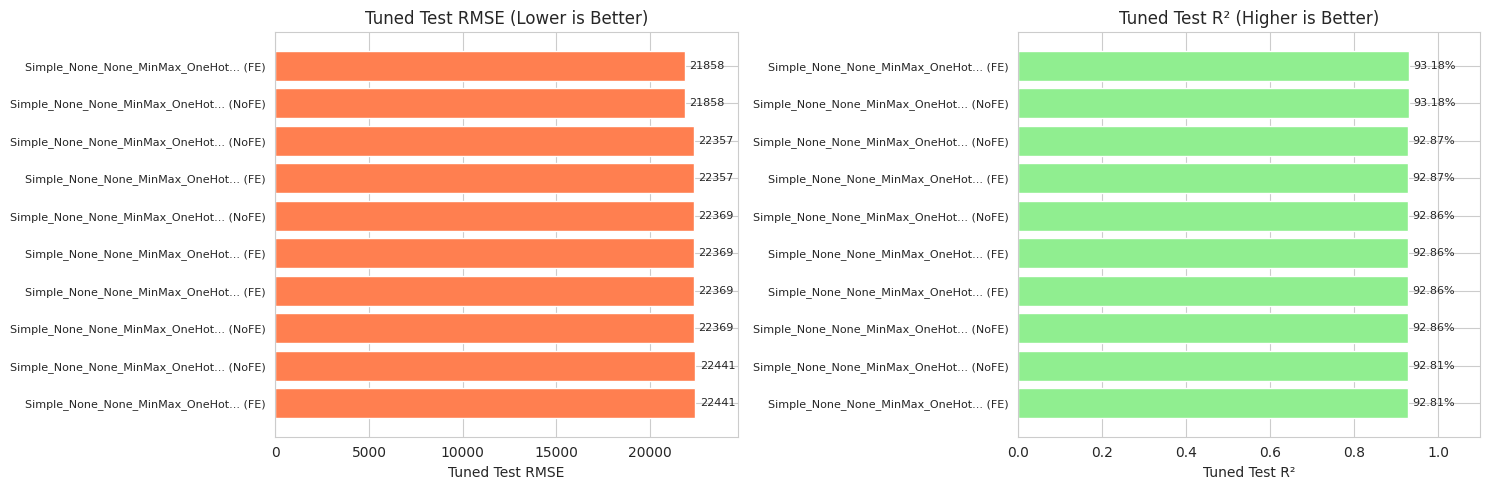

In [ ]:
# Note: FE = With Feature Engineering (True), NoFE = Without Feature Engineering (False)
# Pipeline names are truncated for readability; full names can be viewed in the printed table above.
# For R² values, displaying as percentage (e.g., 0.85 -> 85.00%) rounded to 2 decimal places.
# For RMSE, displaying raw values rounded to 2 decimal places (not percentage, as it's not a ratio).

# Horizontal bar plots for top 10 Tuned metrics (sorted by Tuned_Test_R2 descending)
top10 = results_df.head(10)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Only 2 subplots since no RAE

# Tuned Test RMSE (Lower is Better) - Horizontal bars, add text labels horizontally next to bars
axes[0].barh(range(len(top10)), top10['Tuned_Test_RMSE'], color='coral')
axes[0].set_yticks(range(len(top10)))
labels = [f"{p[:30]}... ({'FE' if w else 'NoFE'})" if len(p) > 30 else f"{p} ({'FE' if w else 'NoFE'})"
          for p, w in zip(top10['Pipeline'], top10['With_FE'])]
axes[0].set_yticklabels(labels, fontsize=8)
axes[0].set_xlabel('Tuned Test RMSE')
axes[0].set_title('Tuned Test RMSE (Lower is Better)')
axes[0].invert_yaxis()

# Add horizontal text labels next to bars (right side, with some padding)
for i, (idx, val) in enumerate(zip(range(len(top10)), top10['Tuned_Test_RMSE'])):
    axes[0].text(val + 0.01 * max(top10['Tuned_Test_RMSE']), idx, f'{val:.0f}',
                 va='center', ha='left', fontsize=8)

# Increase xlim to accommodate labels (add 5-10% padding)
axes[0].set_xlim(0, max(top10['Tuned_Test_RMSE']) * 1.1)

# Tuned Test R² (Higher is Better) - Horizontal bars, add text labels horizontally next to bars
axes[1].barh(range(len(top10)), top10['Tuned_Test_R2'], color='lightgreen')
axes[1].set_yticks(range(len(top10)))
axes[1].set_yticklabels(labels, fontsize=8)  # Reuse labels
axes[1].set_xlabel('Tuned Test R²')
axes[1].set_title('Tuned Test R² (Higher is Better)')
axes[1].invert_yaxis()

# Add horizontal text labels next to bars (right side, with some padding; as %)
for i, (idx, val) in enumerate(zip(range(len(top10)), top10['Tuned_Test_R2'])):
    axes[1].text(val + 0.01, idx, f'{val*100:.2f}%',
                 va='center', ha='left', fontsize=8)

# Increase xlim to accommodate labels (add 5-10% padding)
axes[1].set_xlim(0, 1.1)

plt.tight_layout()
plt.show()


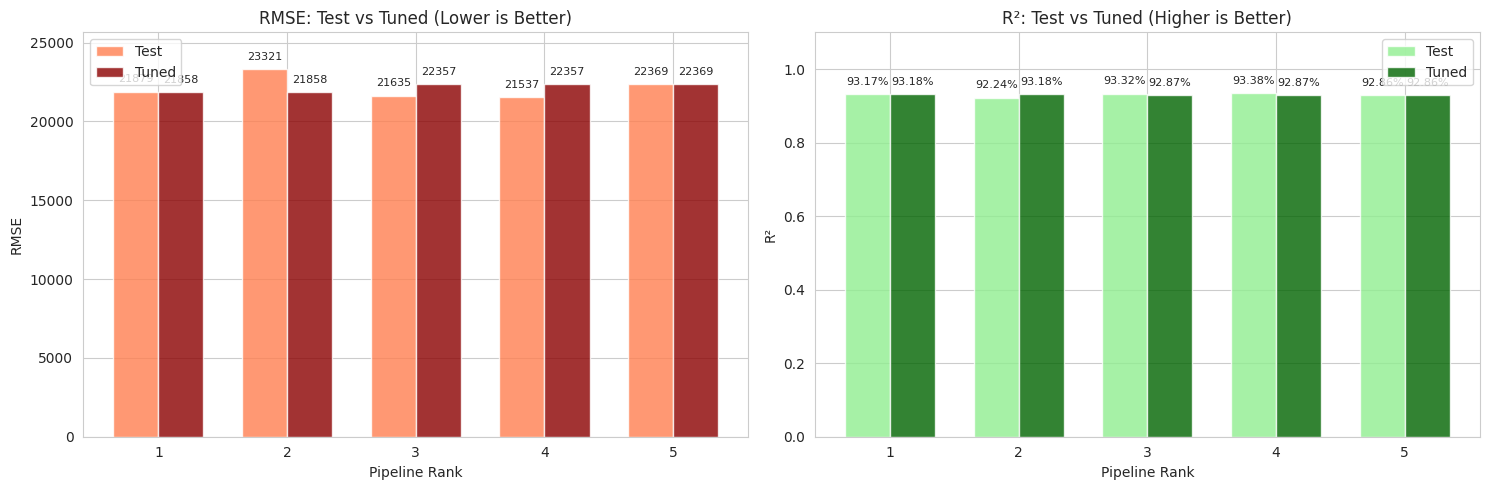

In [ ]:
# Test vs Tuned comparison for top 5 (no Train data available, so Test vs Tuned)
top5 = results_df.head(5)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Only 2 subplots for RMSE and R²

x = np.arange(len(top5))
width = 0.35

# RMSE: Test vs Tuned - Vertical bars, add text labels on top of bars
axes[0].bar(x - width/2, top5['Test_RMSE'], width, label='Test', alpha=0.8, color='coral')
axes[0].bar(x + width/2, top5['Tuned_Test_RMSE'], width, label='Tuned', alpha=0.8, color='darkred')
axes[0].set_xlabel('Pipeline Rank')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE: Test vs Tuned (Lower is Better)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(1, 6))
axes[0].legend()

# Add vertical text labels on top of bars (with some padding)
max_rmse = max(top5['Test_RMSE'].max(), top5['Tuned_Test_RMSE'].max())
for i, (test_val, tuned_val) in enumerate(zip(top5['Test_RMSE'], top5['Tuned_Test_RMSE'])):
    axes[0].text(i - width/2, test_val + 0.02 * max_rmse, f'{test_val:.0f}',
                 ha='center', va='bottom', fontsize=8, rotation=0)
    axes[0].text(i + width/2, tuned_val + 0.02 * max_rmse, f'{tuned_val:.0f}',
                 ha='center', va='bottom', fontsize=8, rotation=0)

# Increase ylim to accommodate labels (add 5-10% padding)
axes[0].set_ylim(0, max_rmse * 1.1)

# R²: Test vs Tuned - Vertical bars, add text labels on top of bars
axes[1].bar(x - width/2, top5['Test_R2'], width, label='Test', alpha=0.8, color='lightgreen')
axes[1].bar(x + width/2, top5['Tuned_Test_R2'], width, label='Tuned', alpha=0.8, color='darkgreen')
axes[1].set_xlabel('Pipeline Rank')
axes[1].set_ylabel('R²')
axes[1].set_title('R²: Test vs Tuned (Higher is Better)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(1, 6))
axes[1].legend()

# Add vertical text labels on top of bars (with some padding; as %)
for i, (test_val, tuned_val) in enumerate(zip(top5['Test_R2'], top5['Tuned_Test_R2'])):
    axes[1].text(i - width/2, test_val + 0.02, f'{test_val*100:.2f}%',
                 ha='center', va='bottom', fontsize=8, rotation=0)
    axes[1].text(i + width/2, tuned_val + 0.02, f'{tuned_val*100:.2f}%',
                 ha='center', va='bottom', fontsize=8, rotation=0)

# Increase ylim to accommodate labels (add 5-10% padding)
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

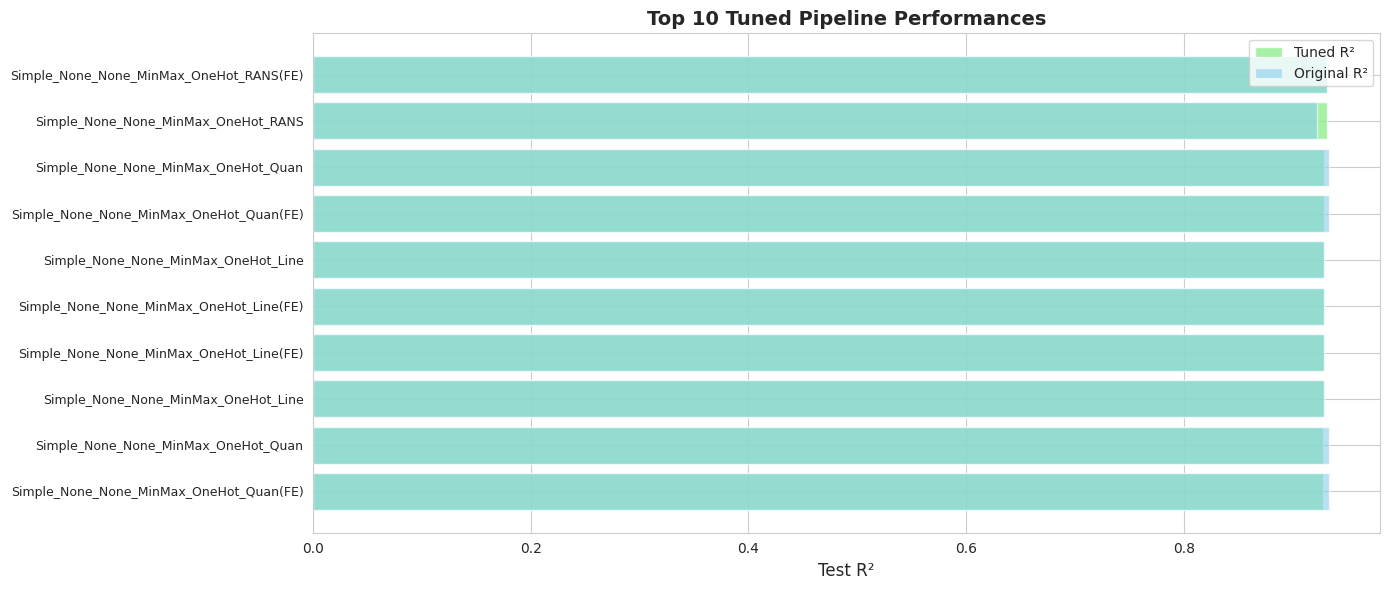

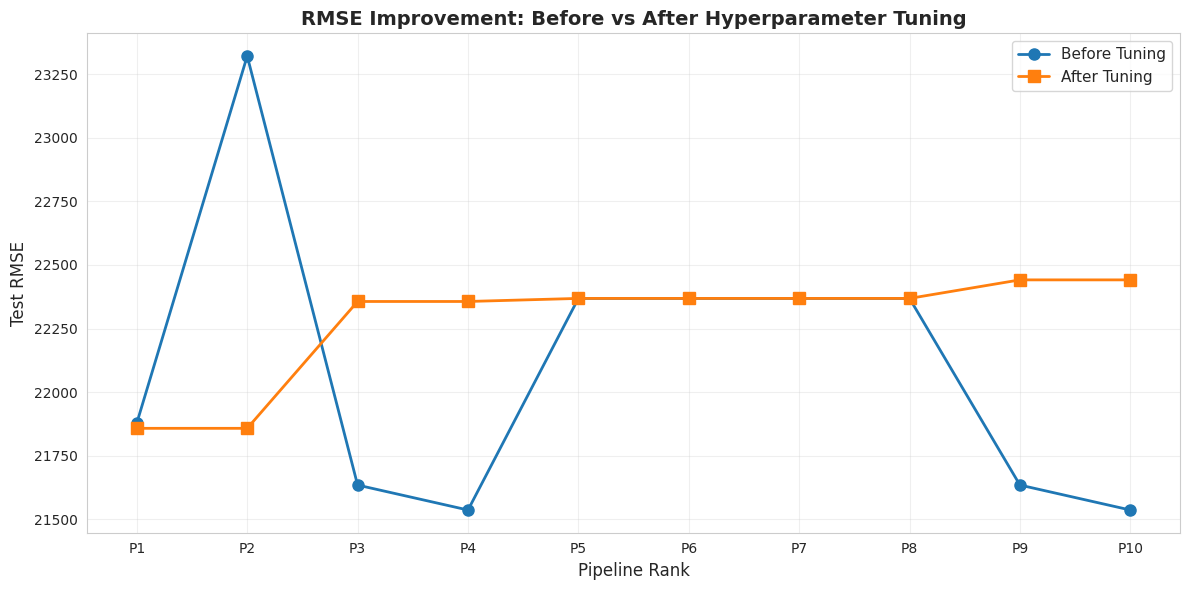

In [ ]:
# 1. Bar chart: Top 10 tuned pipelines
fig, ax = plt.subplots(figsize=(14, 6))
top10 = results_df.head(10)
labels = [f"{p[:35]}{'(FE)' if fe else ''}" for p, fe in zip(top10['Pipeline'], top10['With_FE'])]
x = np.arange(len(top10))

ax.barh(x, top10['Tuned_Test_R2'], color='lightgreen', alpha=0.8, label='Tuned R²')
ax.barh(x, top10['Test_R2'], color='skyblue', alpha=0.6, label='Original R²')
ax.set_yticks(x)
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Test R²', fontsize=12)
ax.set_title('Top 10 Tuned Pipeline Performances', fontsize=14, fontweight='bold')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Line plot: RMSE before/after tuning
fig, ax = plt.subplots(figsize=(12, 6))
top10 = results_df.head(10)
x = np.arange(len(top10))

ax.plot(x, top10['Test_RMSE'], 'o-', label='Before Tuning', linewidth=2, markersize=8)
ax.plot(x, top10['Tuned_Test_RMSE'], 's-', label='After Tuning', linewidth=2, markersize=8)
ax.set_xticks(x)
ax.set_xticklabels([f"P{i+1}" for i in range(len(top10))], fontsize=10)
ax.set_ylabel('Test RMSE', fontsize=12)
ax.set_xlabel('Pipeline Rank', fontsize=12)
ax.set_title('RMSE Improvement: Before vs After Hyperparameter Tuning', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "=" * 80)
print("BENCHMARK SUMMARY:")
print("=" * 80)
print(f"Total pipelines evaluated: {len(results_df)}")
print(f"Total configurations: {len(pipeline_configs)}")
print(f"Models tested: {len(models_to_test)}")
print(f"Pipelines with FE: {len(results_df[results_df['With_FE']])}")
print(f"Pipelines tuned: {len(tuning_df)}")
print(f"\nBest Pipeline: {results_df.iloc[0]['Pipeline']}")
print(f"  - With FE: {results_df.iloc[0]['With_FE']}")
print(f"  - Test R² (original): {results_df.iloc[0]['Test_R2']:.4f}")
print(f"  - Test R² (tuned): {results_df.iloc[0]['Tuned_Test_R2']:.4f}")
print(f"  - Test RMSE (original): {results_df.iloc[0]['Test_RMSE']:.2f}")
print(f"  - Test RMSE (tuned): {results_df.iloc[0]['Tuned_Test_RMSE']:.2f}")
print(f"  - Test RAE: {results_df.iloc[0]['Test_RAE']:.4f}")

# FE Impact Analysis
fe_impact = results_df[results_df['With_FE']].copy()
no_fe_impact = results_df[~results_df['With_FE']].copy()
if len(fe_impact) > 0 and len(no_fe_impact) > 0:
    avg_r2_with_fe = fe_impact['Test_R2'].mean()
    avg_r2_without_fe = no_fe_impact['Test_R2'].mean()
    print(f"\nFeature Engineering Impact:")
    print(f"  - Avg R² without FE: {avg_r2_without_fe:.4f}")
    print(f"  - Avg R² with FE: {avg_r2_with_fe:.4f}")
    print(f"  - Improvement: {((avg_r2_with_fe/avg_r2_without_fe - 1) * 100):.2f}%")

# Tuning Impact
tuned_improvements = results_df.head(10).copy()
tuned_improvements['R2_Improvement'] = ((tuned_improvements['Tuned_Test_R2'] / tuned_improvements['Test_R2'] - 1) * 100)
tuned_improvements['RMSE_Reduction'] = ((tuned_improvements['Test_RMSE'] - tuned_improvements['Tuned_Test_RMSE']) / tuned_improvements['Test_RMSE'] * 100)
print(f"\nHyperparameter Tuning Impact (Top 10):")
print(f"  - Avg R² improvement: {tuned_improvements['R2_Improvement'].mean():.2f}%")
print(f"  - Avg RMSE reduction: {tuned_improvements['RMSE_Reduction'].mean():.2f}%")
print(f"  - Best improvement: {tuned_improvements['R2_Improvement'].max():.2f}%")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

# Export results to CSV
results_df.to_csv('pipeline_benchmark_results.csv', index=False)
print("\nResults saved to 'pipeline_benchmark_results.csv'")


BENCHMARK SUMMARY:
Total pipelines evaluated: 223
Total configurations: 21
Models tested: 7
Pipelines with FE: 73
Pipelines tuned: 10

Best Pipeline: Simple_None_None_MinMax_OneHot_RANSAC
  - With FE: True
  - Test R² (original): 0.9317
  - Test R² (tuned): 0.9318
  - Test RMSE (original): 21879.24
  - Test RMSE (tuned): 21858.19
  - Test RAE: 0.2501

Feature Engineering Impact:
  - Avg R² without FE: 0.5954
  - Avg R² with FE: 0.9121
  - Improvement: 53.20%

Hyperparameter Tuning Impact (Top 10):
  - Avg R² improvement: -0.11%
  - Avg RMSE reduction: -0.87%
  - Best improvement: 1.02%

ANALYSIS COMPLETE

Results saved to 'pipeline_benchmark_results.csv'
